# Cart Pendulum balancing using LQR
This example shows how to use a Linear–quadratic regulator to balance the cart pendulum system

In [2]:
# Set relative path to parent directory
import sys, os
sys.path.insert(0, os.path.abspath('..'))

In [4]:
# Import environment
from environments.cartPendulum import cartPendulum

env = cartPendulum(mass_cart=1, mass_pendulum=0.1, length_pendulum=1, gravity=9.81)
env.step_size = 0.02

LQR is a model based control approach which means we need to know the model of the system in order to use it. the model of the cart pendulum system is given as follows:
$$
    \underbrace{
    \begin{bmatrix}
        1 & 0 & 0 & 0\\
        0 & 1 & 0 & 0\\
        0 & 0 & m_{c} + m_{p} & l m_{p} \cos (\theta)\\
        0 & 0 & \cos (\theta) & l
    \end{bmatrix}
    }_{\boldsymbol{M}}
    \underbrace{
    \begin{bmatrix}
        \dot{x}\\
        \dot{\theta}\\
        \ddot{x}\\
        \ddot{\theta}
    \end{bmatrix}
    }_{\boldsymbol{x}}
    =
    \underbrace{
    \begin{bmatrix}
        \dot{x}\\
        \dot{\theta}\\
        l m_{p} \dot{\theta}^{2} \sin (\theta) + u\\
        g \sin (\theta)
    \end{bmatrix}
    }_{\boldsymbol{F}}
$$

In order to make this more general we will use sympy to do the calculations symbolically

In [42]:
import sympy as sp
sp.init_printing()

# Create the symbolic variabels that we will use
m_c, m_p, l, theta, x, theta_dot, x_dot, u, g = sp.symbols('m_c m_p l theta x theta_dot x_dot u g')

# Compute mass and forcing matrix as given above
mass_matrix = sp.Matrix([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, m_c + m_p, m_p*l*sp.cos(theta)],[0, 0, sp.cos(theta), l]])
forcing_matrix = sp.Matrix([[x_dot], [theta_dot], [m_p*l*theta_dot*theta_dot*sp.sin(theta) + u], [g*sp.sin(theta)]])

We now wish to linearize the system about the equilibrim $\boldsymbol{x} = [\dot{x}, \dot{\theta}, \ddot{x}, \ddot{\theta}]^{\top} = [0, 0, 0, 0]^{\top}$. To do this we first need to get the system on the form:

$$
    \boldsymbol{x} = f(\boldsymbol{x}) = \boldsymbol{M}^{-1}\boldsymbol{F}
$$

To linearize the system we then compute the matrix $\boldsymbol{A}$ and $\boldsymbol{B}$ according to: 

$$
\boldsymbol{A} 
=
\frac{\partial f}{\partial \boldsymbol{x}}  \bigg|_{\boldsymbol{x} = 0}
=
\begin{bmatrix}
    \frac{\partial f_1}{\partial x_1}  & \cdots & \frac{\partial f_1}{\partial x_n}  \\
    \vdots          &        & \vdots          \\
    \frac{\partial f_n}{\partial x_1}  & \cdots & \frac{\partial f_n}{\partial x_n} 
\end{bmatrix}\Bigg|_{\boldsymbol{x} = 0}
$$

$$
\boldsymbol{B} 
=
\frac{\partial f}{\partial \boldsymbol{x}}  \bigg|_{\boldsymbol{x} = 0}
=
\begin{bmatrix}
    \frac{\partial f_1}{\partial u} \\
    \vdots \\
    \frac{\partial f_n}{\partial u}
\end{bmatrix}\Bigg|_{\boldsymbol{x} = 0}
$$


In [54]:
# find f(x) as specified above
f = mass_matrix.inv()@forcing_matrix

# Compute the jacobain of the system
J = sp.Matrix([sp.diff(f, x).T, sp.diff(f, theta).T, sp.diff(f, x_dot).T, sp.diff(f, theta_dot).T]).T

# Compute A and B
A = sp.simplify(J.subs({x: 0, theta: 0 , x_dot : 0, theta_dot : 0}))
B = sp.simplify(sp.diff(f, u).subs({x: 0, theta: 0 , x_dot : 0, theta_dot : 0}))

A, B

⎛⎡0       0        1  0⎤, ⎡  0  ⎤⎞
⎜⎢                     ⎥  ⎢     ⎥⎟
⎜⎢0       0        0  1⎥  ⎢  0  ⎥⎟
⎜⎢                     ⎥  ⎢     ⎥⎟
⎜⎢      -g⋅mₚ          ⎥  ⎢  1  ⎥⎟
⎜⎢0     ──────     0  0⎥  ⎢ ─── ⎥⎟
⎜⎢       m_c           ⎥  ⎢ m_c ⎥⎟
⎜⎢                     ⎥  ⎢     ⎥⎟
⎜⎢   g⋅(m_c + mₚ)      ⎥  ⎢ -1  ⎥⎟
⎜⎢0  ────────────  0  0⎥  ⎢─────⎥⎟
⎝⎣      l⋅m_c          ⎦  ⎣l⋅m_c⎦⎠

As a sidenote, computing the eigenvalues of the system gives:


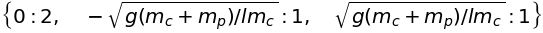

In [57]:
A.eigenvals()

Where we have a pole with positive real part, from lyapunovs indirect method we can conclude that the origin is an unstable equilibrium point. 